In [8]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import seaborn as sns
sys.path.append('/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM')

In [14]:
lsm = pd.read_csv('/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/logs/MonthlySwing/evaluations/lsm.csv')
lsm.query('path == 0')

,path,time_step,spot,q_exercised_so_far,q_t,payoff
0,0,0,1.000000,0.0,0.0,0.000000
4096,0,1,0.987244,0.0,0.0,0.000000
8192,0,2,1.111259,0.0,0.0,0.000000
12288,0,3,1.732804,0.0,2.0,1.465608
16384,0,4,1.544227,2.0,2.0,1.088453
20480,0,5,1.422490,4.0,2.0,0.844980
24576,0,6,1.655626,6.0,2.0,1.311253
28672,0,7,1.605626,8.0,2.0,1.211251
32768,0,8,1.485820,10.0,2.0,0.971641
36864,0,9,1.444852,12.0,2.0,0.889703


Mean payoff: 2.671309


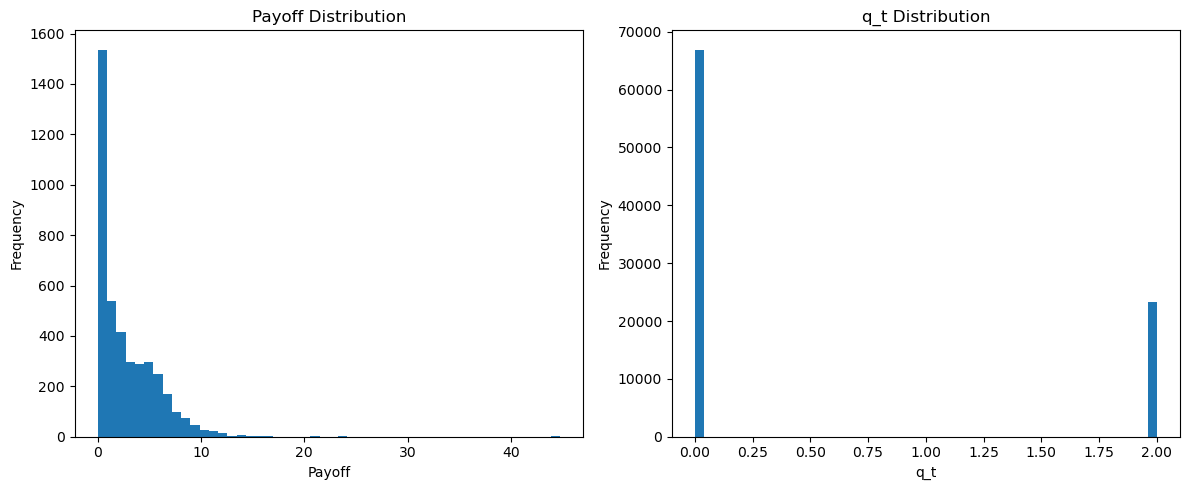

In [ ]:
# lsm = pd.read_csv('/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/logs/MonthlySwing/evaluations/lsm.csv')
payoffs_paths = lsm.groupby('path').aggregate({'payoff':'sum'})['payoff']

mean_payoff = payoffs_paths.mean()
print(f'Mean payoff: {mean_payoff:4f}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

payoffs_paths.plot(
    kind='hist',
    bins=50,
    ax=axes[0],
    title='Payoff Distribution'
)
axes[0].set_xlabel('Payoff')
axes[0].set_ylabel('Frequency')

lsm['q_t'].plot(
    kind='hist',
    bins=50,
    ax=axes[1],
    title='q_t Distribution'
)
axes[1].set_xlabel('q_t')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

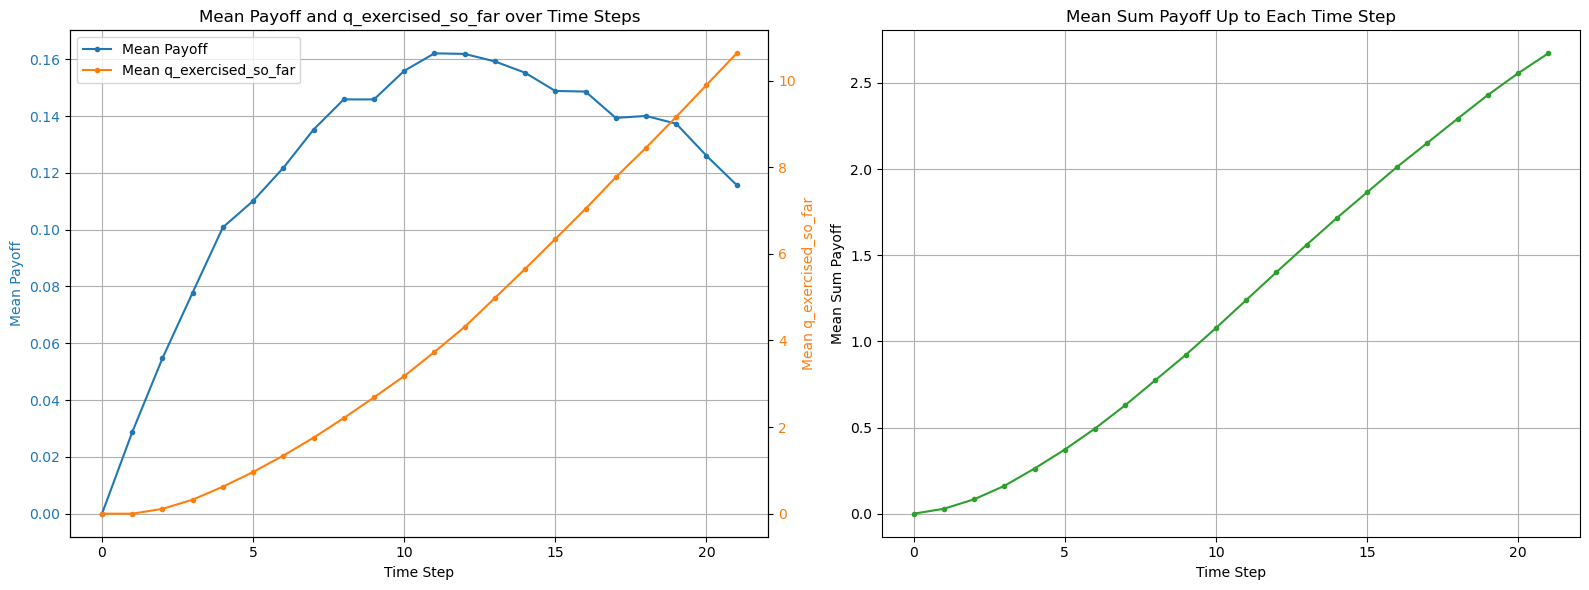

In [10]:
grouped = lsm.groupby('time_step').aggregate({
    'payoff': 'mean',
    'q_exercised_so_far': 'mean'
})

sum_payoff_up_to_time_step = {}
for time_step in grouped.index:
    sum_payoff_up_to_time_step[time_step] = grouped.loc[:time_step, 'payoff'].sum()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Left: Mean Payoff and q_exercised_so_far over Time Steps (dual y-axis)
ax1 = axs[0]
color1 = 'tab:blue'
color2 = 'tab:orange'
ln1 = ax1.plot(grouped.index, grouped['payoff'], color=color1, label='Mean Payoff', marker='.')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Mean Payoff', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title('Mean Payoff and q_exercised_so_far over Time Steps')
ax1.grid(True)

ax2 = ax1.twinx()
ln2 = ax2.plot(grouped.index, grouped['q_exercised_so_far'], color=color2, label='Mean q_exercised_so_far', marker='.')
ax2.set_ylabel('Mean q_exercised_so_far', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
# ax2.grid(True)

lns = ln1 + ln2
labels = ['Mean Payoff', 'Mean q_exercised_so_far']
ax1.legend(lns, labels, loc='upper left')

# Right: Mean Sum Payoff Up to Each Time Step
axs[1].plot(list(sum_payoff_up_to_time_step.keys()), list(sum_payoff_up_to_time_step.values()), marker='.', color='tab:green')
axs[1].set_title('Mean Sum Payoff Up to Each Time Step')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Mean Sum Payoff')
axs[1].grid()
# axs[1].set_xticks(np.arange(0, max(time_steps) + 1, 1))

plt.tight_layout()
plt.show()

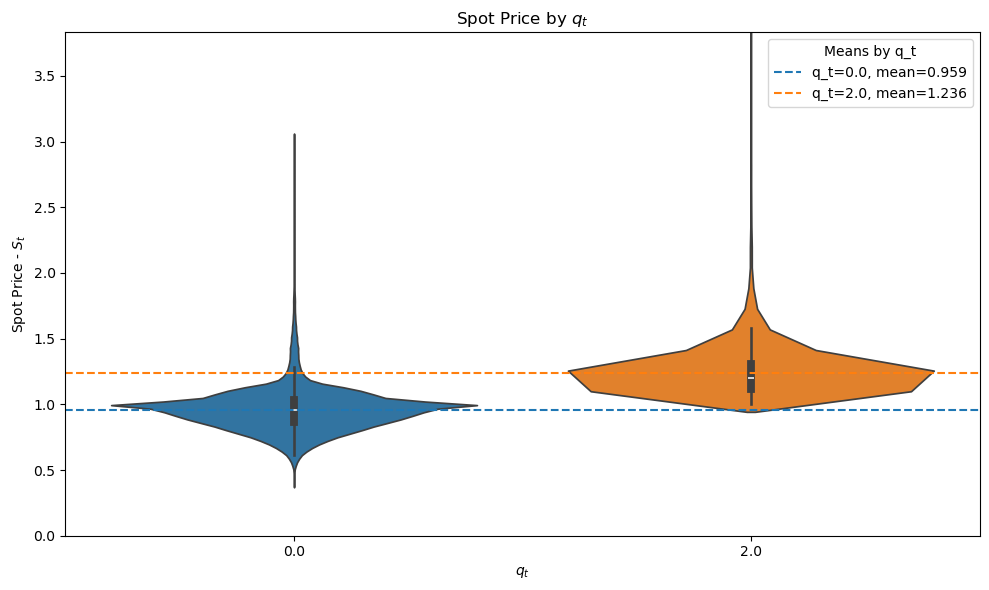

In [11]:
unique_qt = sorted(lsm['q_t'].unique())
palette = dict(zip(unique_qt, sns.color_palette('tab10', n_colors=len(unique_qt))))

plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    x='q_t',
    y='spot',
    data=lsm,
    hue='q_t',
    palette=palette,
    legend=False
)
ax.set_title(r'Spot Price by $q_t$')
ax.set_xlabel(r'$q_t$')
ax.set_ylabel(r'Spot Price - $S_t$')
plt.ylim(0, lsm['spot'].quantile(0.9999))

# Calculate means for each group
means = lsm.groupby('q_t')['spot'].mean()
# Add horizontal lines for each group's mean
for q, mean in means.items():
    ax.axhline(mean, linestyle='--', color=palette[q], label=f'q_t={q:.1f}, mean={mean:.3f}')

plt.legend(title='Means by q_t')
plt.tight_layout()
plt.show()

---
# Figure 10 - 100

In [12]:
import sys

# Add the project root directory to Python path
sys.path.append('/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM')

from src.simulate_hhk_spot import no_seasonal_function, simulate_hhk_spot
from src.swing_contract import SwingContract
from src.lsm_swing_pricer import price_swing_option_lsm
from run import generate_datasets

swing_contract = SwingContract(
    q_min=0,
    q_max=1,
    Q_min=0,
    Q_max=100,
    strike=1,
    maturity=1.0,
    n_rights=100,
    r=0.0,
    min_refraction_days=0,
)

stochastic_process_params = {
    "S0": 1,
    "T": swing_contract.maturity,
    "n_steps": swing_contract.n_rights,
    "alpha": 7.0,
    "sigma": 1.4,
    "beta": 200.,
    "lam": 4.0,
    "mu_J": 0.4,
    "f": no_seasonal_function,
}

train_ds, eval_ds = generate_datasets(
    stochastic_process_params=stochastic_process_params,
    n_paths=16384,
    n_paths_eval=4096,
    seed=1,
)

mean_lsm_price, (th5q_price,th95q_price) = price_swing_option_lsm(
    contract=swing_contract,
    dataset=eval_ds,
    poly_degree=3, seed=1
)

🎲 Generating datasets: 16384 training + 4096 eval paths...


>>>> shape of train_S: (16384, 101)


✅ Datasets generated in 0.65s (47.3 MB)


AssertionError: Mismatch between paths and contract rights